In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as torch

from splice.splice import SPLICE

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
torch.cuda.empty_cache()

### private angle

#### load model and data

In [62]:
train = np.load("../data/sprites/single-pose_private-angle_train.npz")
test = np.load("../data/sprites/single-pose_private-angle_test.npz")

In [63]:
A_train = torch.Tensor(train["view1"]).to(device).reshape(-1, 64*64*3)
B_train = torch.Tensor(train["view2"]).to(device).reshape(-1, 64*64*3)

A_test = torch.Tensor(test["view1"]).to(device).reshape(-1, 64*64*3)
B_test = torch.Tensor(test["view2"]).to(device).reshape(-1, 64*64*3)

In [64]:
model = SPLICE(
    n_a=64 * 64 * 3,
    n_b=64 * 64 * 3,
    n_private_a=2,
    n_private_b=2,
    n_shared=500,
    conv=False,
    enc_layers = [1024, 512, 512, 2048, 1024, 512],
    dec_layers = [512, 1024, 2048, 512, 512, 1024],
    msr_layers = [512, 1024, 2048, 512, 512, 1024],
    size=None,
).to(device)

filepath = os.path.join("..","results", "models", "sprites", "splice_sprites_private-angle.pt")

model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [65]:
A_test.shape

torch.Size([5000, 12288])

In [66]:
z_a, z_b2a, z_a2b, z_b, m_a2b, m_b2a, a_hat, b_hat = model(A_test, B_test)

z_a = z_a.cpu().detach().numpy()
z_b = z_b.cpu().detach().numpy()

In [67]:
mse = torch.nn.functional.mse_loss(a_hat, A_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(A_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/A_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((A_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ A_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.959297

In [68]:
mse = torch.nn.functional.mse_loss(b_hat, B_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(B_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/B_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((B_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ B_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.9619519

#### plot latent space vs angle

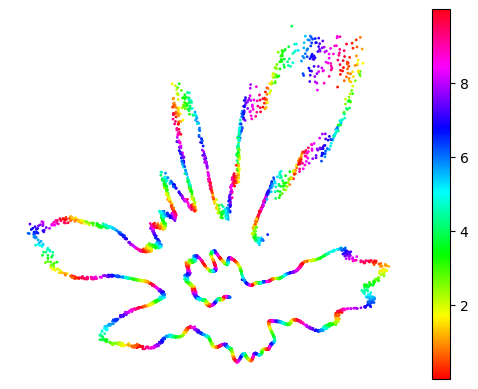

In [84]:
test_angles = test["angles"]
plt.scatter(z_a[:, 0], z_a[:, 1], c=(test_angles[:,0])%10, s=1, cmap="hsv")
plt.axis("off")
plt.colorbar()
# plt.savefig("../figures/sprites_private_angle_z_a.png", dpi=300, bbox_inches="tight")

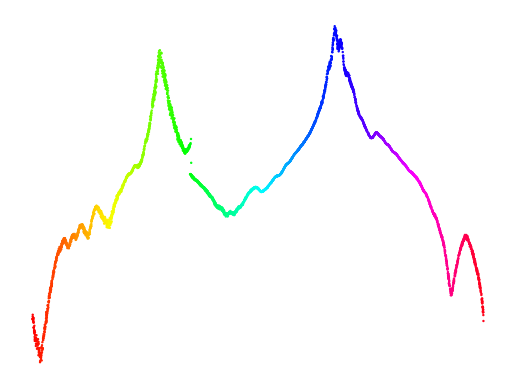

In [70]:
plt.scatter(test_angles[:,0], z_a[:,0], s=0.5,c=test_angles[:,0], cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_private_angle_za_vs_theta.png", dpi=300, bbox_inches="tight")

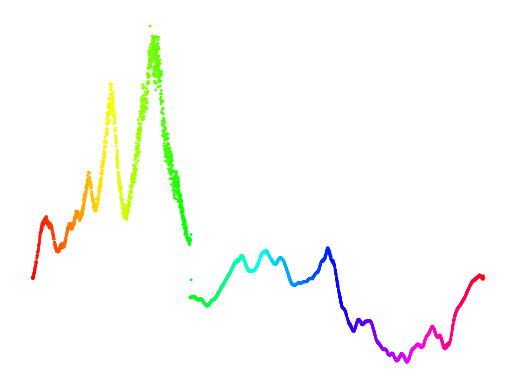

In [71]:
plt.scatter(test_angles[:,0], z_a[:,1], s=1, cmap="hsv", c =test_angles[:,0])
plt.axis("off")
plt.savefig("../figures/sprites_private_angle_za1_vs_theta.png", dpi=300, bbox_inches="tight")

In [72]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles[:,0])
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_a[:,0])
var_2 = np.var(z_a[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles[:,0] >= start) & (test_angles[:,0] < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_a[angle_inds, 0]))
        window_vars_2.append(np.var(z_a[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print(1-avg_var_1 , 1-avg_var_2)

0.9989588225726038 0.9967546707484871


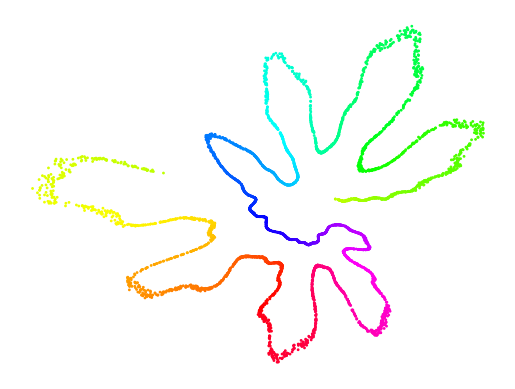

In [73]:
test_angles = test["angles"]
plt.scatter(z_b[:, 0], z_b[:, 1], c=test_angles[:,1], s=1, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_private_angle_z_b.png", dpi=300, bbox_inches="tight")

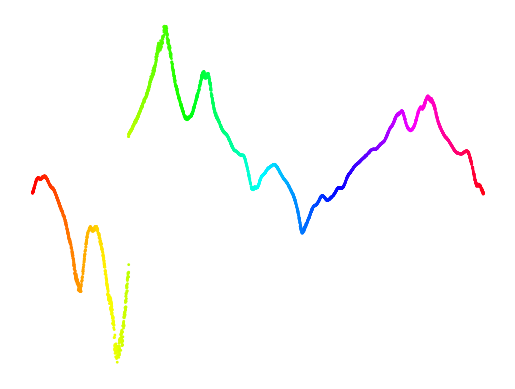

In [74]:
plt.scatter(test_angles[:,1], z_b[:,0], s=1, c=test_angles[:,1], cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_private_angle_zb0_vs_theta.png", dpi=300, bbox_inches="tight")

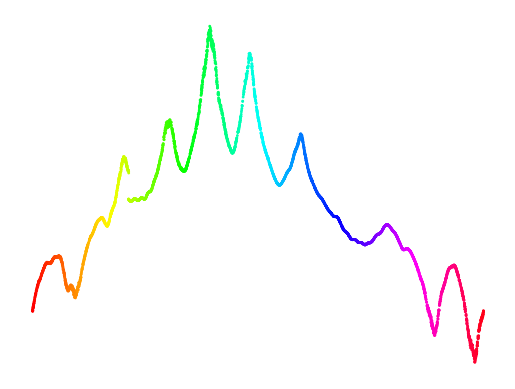

In [75]:
plt.scatter(test_angles[:,1], z_b[:,1], s=1, c=test_angles[:,1], cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_private_angle_zb1_vs_theta.png", dpi=300, bbox_inches="tight")

In [77]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles[:,1])
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_b[:,0])
var_2 = np.var(z_b[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles[:,1] >= start) & (test_angles[:,1] < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_b[angle_inds, 0]))
        window_vars_2.append(np.var(z_b[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print((1-avg_var_1 + 1-avg_var_2)/2)

0.9977309649402741


#### plot reconstructions

### shared angle

In [46]:
torch.cuda.empty_cache()
train = np.load("../data/sprites/single-pose_shared-angle_train.npz")
test = np.load("../data/sprites/single-pose_shared-angle_test.npz")

In [47]:
A_train = torch.Tensor(train["view1"]).to(device).reshape(-1, 64*64*3)
B_train = torch.Tensor(train["view2"]).to(device).reshape(-1, 64*64*3)

A_test = torch.Tensor(test["view1"]).to(device).reshape(-1, 64*64*3)
B_test = torch.Tensor(test["view2"]).to(device).reshape(-1, 64*64*3)

In [48]:
model = SPLICE(
    n_a=64 * 64 * 3,
    n_b=64 * 64 * 3,
    n_private_a=500,
    n_private_b=500,
    n_shared=2,
    conv=False,
    enc_layers = [1024, 512, 512, 2048, 1024, 512],
    dec_layers = [512, 1024, 2048, 512, 512, 1024],
    msr_layers = [512, 1024, 2048, 512, 512, 1024],
    size=None,
).to(device)

filepath = os.path.join("..","results", "models", "sprites", "splice_sprites_shared-angle.pt")

model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [49]:
z_a, z_b2a, z_a2b, z_b, m_a2b, m_b2a, a_hat, b_hat = model(A_test, B_test)

z_a = z_a.cpu().detach().numpy()
z_b = z_b.cpu().detach().numpy()
z_a2b = z_a2b.cpu().detach().numpy()
z_b2a = z_b2a.cpu().detach().numpy()

In [50]:
mse = torch.nn.functional.mse_loss(a_hat, A_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(A_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/A_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((A_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ A_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.96135575

In [51]:
mse = torch.nn.functional.mse_loss(b_hat, B_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(B_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/B_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((B_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ B_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.96078837

#### plot latent space vs angle

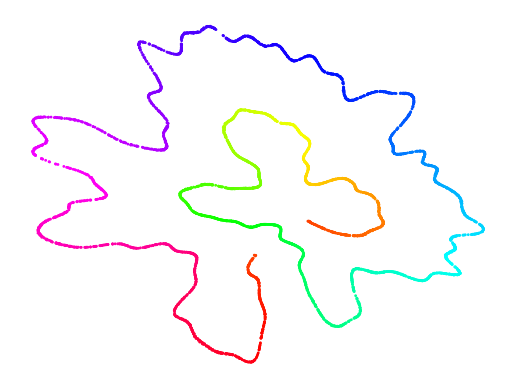

In [52]:
test_angles = test["angles"]
plt.scatter(z_a2b[:, 0], z_a2b[:, 1], c=test_angles, s=1, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_z_a2b.png", dpi=300, bbox_inches="tight")

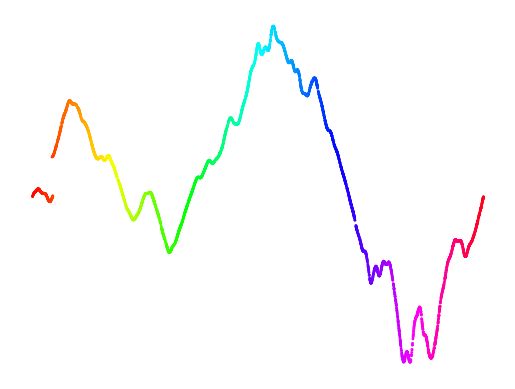

In [53]:
plt.scatter(test_angles, z_a2b[:,0], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_za2b_vs_theta.png", dpi=300, bbox_inches="tight")

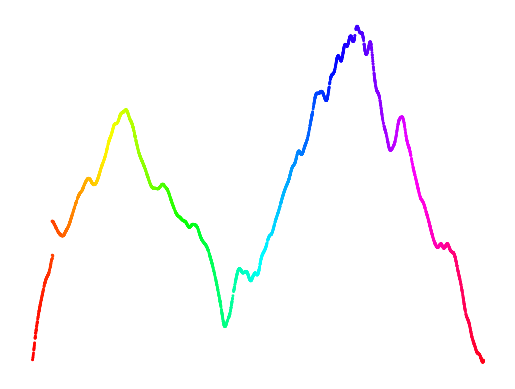

In [54]:
plt.scatter(test_angles, z_a2b[:,1], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_za2b1_vs_theta.png", dpi=300, bbox_inches="tight")

In [60]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles)
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_a2b[:,0])
var_2 = np.var(z_a2b[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles >= start) & (test_angles < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_a2b[angle_inds, 0]))
        window_vars_2.append(np.var(z_a2b[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print((1-avg_var_1 + 1-avg_var_2)/2)

0.9996082763391314


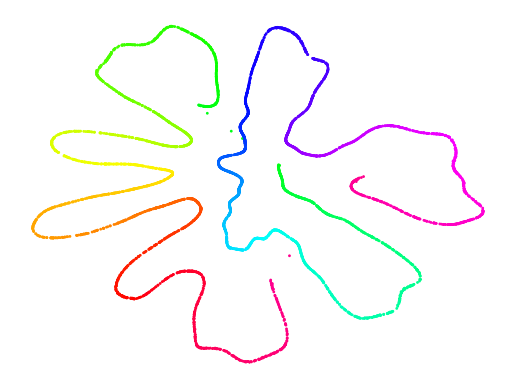

In [56]:
test_angles = test["angles"]
plt.scatter(z_b2a[:, 0], z_b2a[:, 1], c=test_angles, s=1, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_z_b2a.png", dpi=300, bbox_inches="tight")

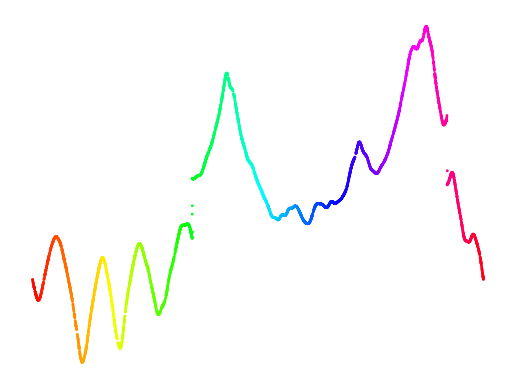

In [57]:
plt.scatter(test_angles, z_b2a[:,0], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_zb2a0_vs_theta.png", dpi=300, bbox_inches="tight")

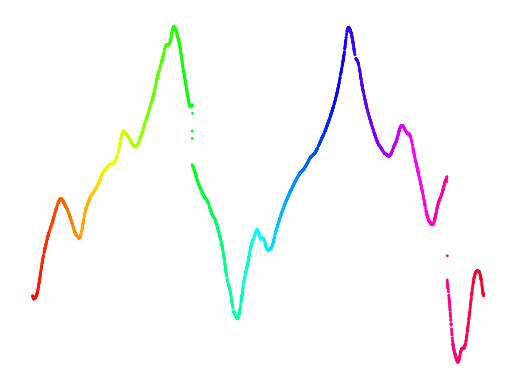

In [58]:
plt.scatter(test_angles, z_b2a[:,1], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_zb2a1_vs_theta.png", dpi=300, bbox_inches="tight")

In [59]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles)
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_b2a[:,0])
var_2 = np.var(z_b2a[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles >= start) & (test_angles < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_b2a[angle_inds, 0]))
        window_vars_2.append(np.var(z_b2a[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print(1-avg_var_1 , 1-avg_var_2)

0.9990585190826096 0.9986434209858999


#### plot reconstructions